In [1]:
%load_ext autoreload
%autoreload 2
from corr_study.datasetApi import *
from corr_study.correlation import *
from corr_study.voxels import *
from corr_study.mobileclassifier import *
from corr_study.truthsetter import *
from corr_study.simulation import *
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import tikzplotlib
import matplotlib
from tqdm import tqdm

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = 64/9, 4

dataset = Dataset("corr_study/dataset/")

route = dataset.get_routes_TLC()[0]
ids = dataset.get_ids_CV(Town.T1, Weather.Clear, Time.Sunset, Sensor.LFL)

route = dataset.get_routes_TLC()[0]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-03-29 16:50:19.895352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# LiteUNet

In [2]:
train, val, test, len_train, len_val, len_test = create_tf_dataset(dataset, [["t3high", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3medium", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3low", Weather.Clear, Time.Sunset, Sensor.LT],], 4)
m = get_model((1024,1024,2))
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
m.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryAccuracy()], run_eagerly = True)

2023-03-15 12:27:30.053702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 12:27:30.054587: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping("val_loss", patience=3, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("network.h5", monitor="val_loss", save_best_only=True)]

history = m.fit(train, steps_per_epoch=int(np.ceil(len_train/4)), epochs=10, validation_data=val, validation_steps=int(np.ceil(len_val/4)), callbacks=callbacks)

In [25]:
s = train.take(1)

1/1 [==============================] - 1s 1s/step


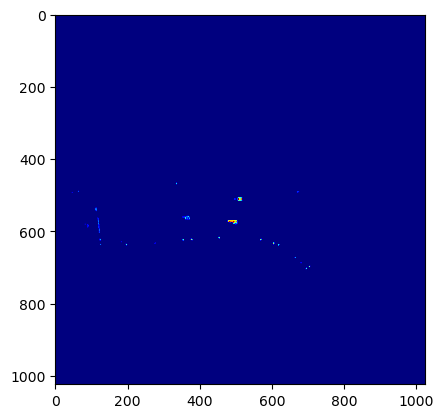

(array([0., 1.]), array([738538, 310038]))


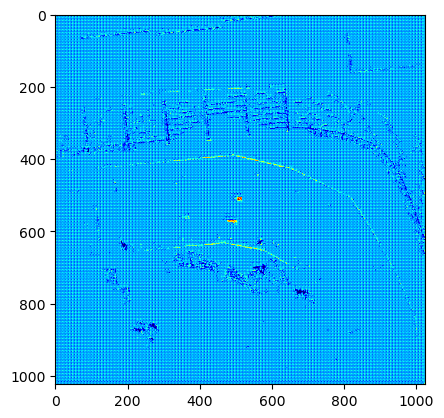

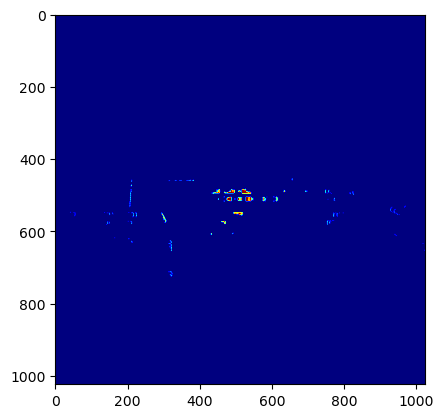

(array([0., 1.]), array([738105, 310471]))


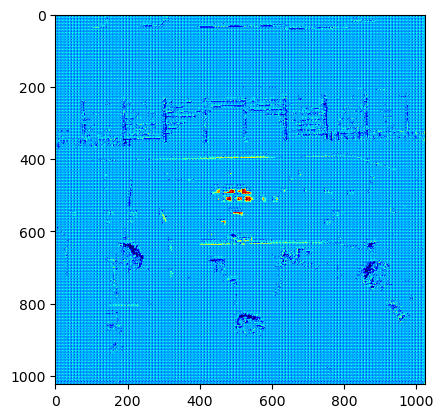

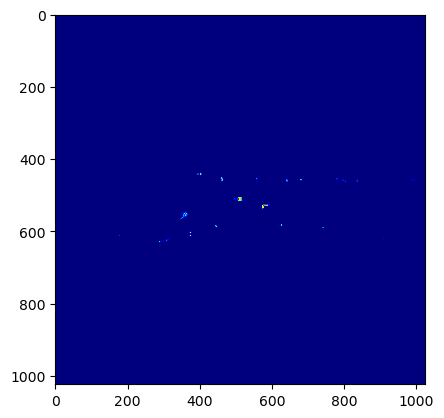

(array([0., 1.]), array([738489, 310087]))


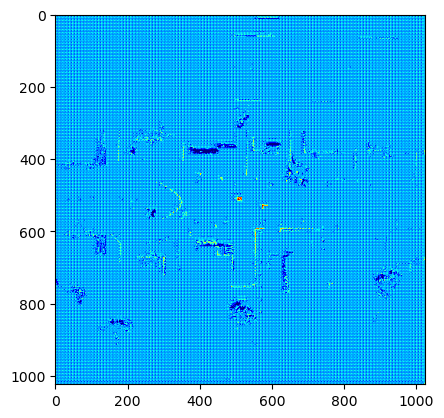

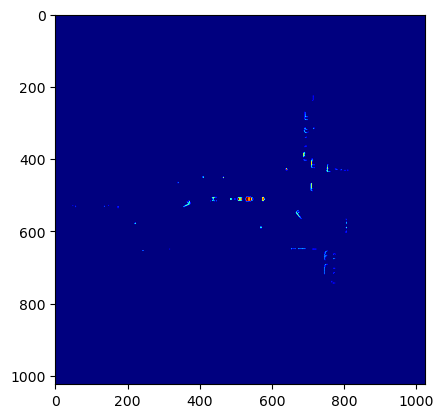

(array([0., 1.]), array([739069, 309507]))


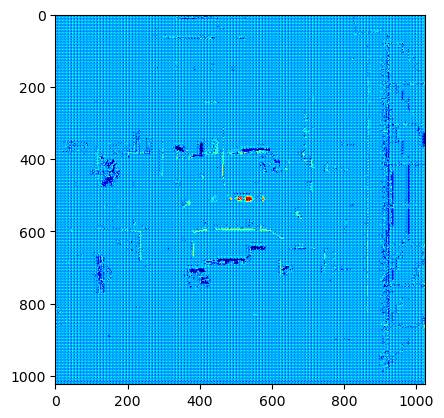

In [28]:
for x, y in s:
    pred = m.predict(x)
    pred = pred>.5
    pred = pred.astype(float)
    for i in range(4):
        # plt.imshow(x[i,:,:,0], vmin=0, vmax=1, cmap='jet')
        # plt.show()
        # plt.imshow(x[i,:,:,1], vmin=0, vmax=1, cmap='jet')
        # plt.show()
        plt.imshow(y[i,:,:,0], vmin=0, vmax=1, cmap='jet')
        plt.show()
        plt.imshow(pred[i,:,:,0], vmin=0, vmax=1, cmap='jet')
        print(np.unique(pred[i,:,:,0], return_counts=True))
        plt.show()

# MiniUNet

In [ ]:
train, val, test, len_train, len_val, len_test = create_tf_dataset(dataset, [["t3high", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3medium", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3low", Weather.Clear, Time.Sunset, Sensor.LT],], 4)
m = get_miniUNet((1024,1024,2))
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha=.9)
m.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()], run_eagerly = True)

callbacks = [tf.keras.callbacks.EarlyStopping("val_loss", patience=3, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("network.h5", monitor="val_loss", save_best_only=True)]

history = m.fit(train, steps_per_epoch=100, epochs=10, validation_data=val, validation_steps=13, callbacks=callbacks)

In [24]:
m = tf.keras.models.load_model('network_miniUNet.h5')
cmap = "Greens" 
s = test.take(1)
for x, y in s:
    pred = m.predict(x)
    pred = pred>.5
    pred = pred.astype(float)
    for i in range(4):
        fig, ax = plt.subplots(1,3,figsize=(30,10))
        ax[0].imshow(x[i,:,:,1])
        ax[1].imshow(y[i,:,:,0], vmin=0, vmax=1, cmap=cmap)
        ax[2].imshow(pred[i,:,:,0], vmin=0, vmax=1, cmap=cmap)
        plt.show()

NameError: name 'test' is not defined

# Non machine-learning

In [2]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation.append(correla)

In [4]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_cluster_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation.append(correla)

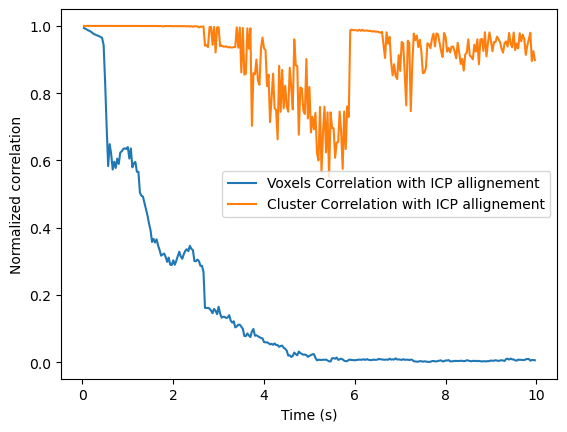

In [5]:
fig, ax = plt.subplots(1,1)
pp, = ax.plot(np.arange(1,300)/30, icp_correlation)
pc, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized correlation")
ax.legend([pp, pc],["Voxels Correlation with ICP allignement", "Cluster Correlation with ICP allignement"])
plt.show()

In [59]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_cluster_mse = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation, return_mse=True)
    icp_cluster_mse.append(correla)

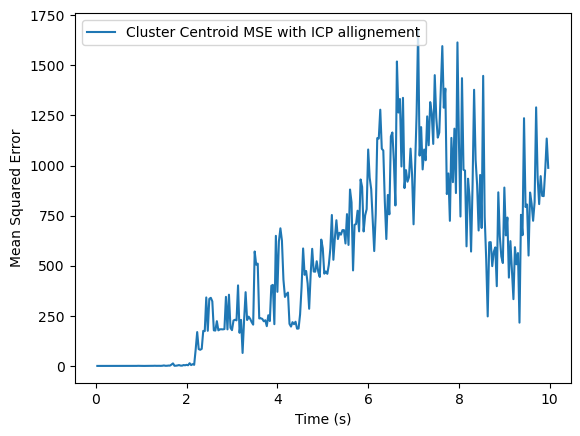

In [60]:
fig, ax = plt.subplots(1,1)
pmse, = ax.plot(np.arange(1,300)/30, icp_cluster_mse)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mean Squared Error")
ax.legend([pmse],["Cluster Centroid MSE with ICP allignement"])
plt.show()

In [50]:

pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 120)
correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 30, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=None)

In [5]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
center_mass_corr = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    center_mass_corr.append(pcd_top.compare_using_voxels(pcd_top_compare, 0.5))

In [7]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
v_top = pcd_top.voxelize(0.5)
corr = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    corr.append(v_top.compute_correlation(pcd_top_compare.voxelize(0.5, v_top.boundaries)))


In [8]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
v_top = pcd_top.voxelize(0.5)
cross_corr = []
for i in range(1, 101, 1):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cross_corr.append(v_top.compute_correlation_inferring_offset(pcd_top_compare.voxelize(0.5, v_top.boundaries)))

In [9]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
center_mass_corr_weighted = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    center_mass_corr_weighted.append(pcd_top.compare_using_voxels(pcd_top_compare, 0.5, weighted=True))

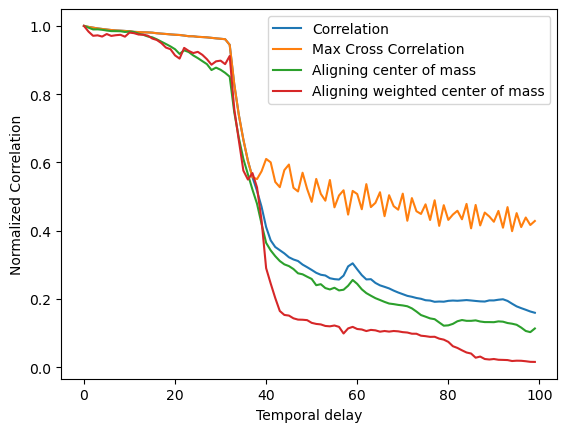

In [10]:
fig, ax = plt.subplots(1,1)
c, = ax.plot(corr)
cc, = ax.plot(cross_corr)
cm, = ax.plot(center_mass_corr)
cmw, = ax.plot(center_mass_corr_weighted)
ax.legend([c, cc, cm, cmw], ["Correlation", "Max Cross Correlation", "Aligning center of mass", "Aligning weighted center of mass"])
plt.ylabel("Normalized Correlation")
plt.xlabel("Temporal delay")
plt.show()

In [30]:
dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 32).visualize()
dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 35).visualize()

In [3]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
mse_mass_center = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    mse_mass_center.append(pcd_top.compare_using_clusters(pcd_top_compare, 10))


In [4]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
mse_mass_center_w = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    mse_mass_center_w.append(pcd_top.compare_using_clusters(pcd_top_compare, 10, weighted=True))


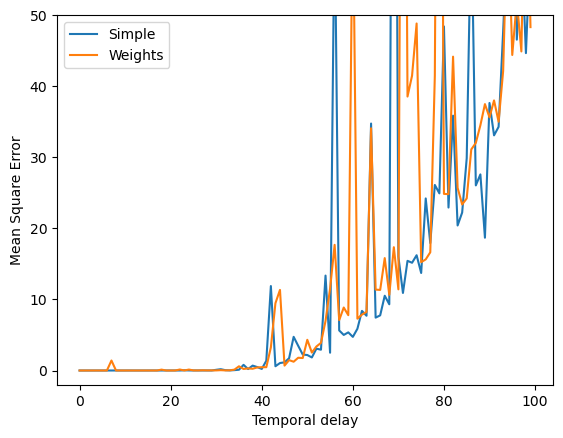

In [5]:
fig, ax = plt.subplots(1,1)
s, = ax.plot(mse_mass_center)
w, = ax.plot(mse_mass_center_w)
ax.legend([s, w], ["Simple", "Weights"])
plt.ylabel("Mean Square Error")
plt.xlabel("Temporal delay")
ax.set_ylim([-2,50])
plt.show()

In [13]:
def compute_oddly_normalized_distance(points):
    dists_matrix = np.sqrt(np.sum((points[:, np.newaxis] - points) ** 2, axis=-1))
    distances = np.sqrt(np.sum(points ** 2, axis=1))
    distances = distances[:, np.newaxis]* distances
    return dists_matrix/distances

clustering = DBSCAN(eps=0.001, min_samples=10, metric="precomputed").fit(compute_oddly_normalized_distance(pcd_top.data[15000:30000,:]))
clusters = SelmaPointCloud(pcd_top.data[15000:30000,:], clustering.labels_)
clusters.visualize()

In [65]:
pcd_1 = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
pcd_2 = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 2)
a = np.zeros(pcd_1.data.shape[0], dtype=int) - 1
b = np.zeros(pcd_2.data.shape[0], dtype=int) + 1
gt = np.concatenate((a,b))

SelmaPointCloud(np.concatenate((pcd_1.data, pcd_2.data), axis = 0), ground_truth=gt).visualize()

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


In [96]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
target = []
for i in range(1, 11):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    target.append(pcd_top_compare.data)
mse = pcd_top.compare_using_dbscan(target, 0.05, 100)
print(mse)

100%|██████████| 43/43 [00:32<00:00,  1.33it/s]
c:\Users\Filippo\Desktop\uni\thesis\pqos-correlation\corr_study\selmaPointCloud.py:202: RuntimeWarning: Mean of empty slice.
  centroid_second = data_second[labels_second == i].mean(axis=0)
 36%|███▌      | 15/42 [00:07<00:08,  3.09it/s]c:\Users\Filippo\Desktop\uni\thesis\pqos-correlation\corr_study\selmaPointCloud.py:183: RuntimeWarning: Mean of empty slice.
  #     centroid_first = first_pointcloud[labels_first == i].mean(axis=0)
100%|██████████| 32/32 [00:13<00:00,  2.37it/s]

[0.06319631789131108, 0.049311042558667174, 0.016931637428582925, 0.01743789419418201, 0.010877727385090167, 0.013613972508210883, 0.012093654171819205, 0.012134498149744159, 0.012158936521786144, 0.011885721548165319]


# Dropping Correlation

In [3]:
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
import h5py
import numpy as np
from pathlib import Path

filepath = Path(fp)
loc = None
rot = None
with h5py.File(filepath,'r') as f:
    root_grp = f.get("BBOX")
    ids = list(root_grp.keys())
    ego = root_grp.get("0194")
    loc = np.array(ego.get('location'))
    rot = np.array(ego.get('rotation'))
print(rot.min())

-179.9951


In [25]:
import open3d as o3d
import seaborn as sns

def create_homogeneous_matrix(x, y, z, pitch, yaw, roll):
    # Convert pitch, yaw, and roll angles to radians
    pitch = np.radians(pitch)
    yaw = np.radians(yaw)
    roll = np.radians(roll)

    # Create rotation matrices for each angle
    Rx = np.array([[1, 0, 0], [0, np.cos(pitch), -np.sin(pitch)], [0, np.sin(pitch), np.cos(pitch)]])
    Ry = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
    Rz = np.array([[np.cos(roll), -np.sin(roll), 0], [np.sin(roll), np.cos(roll), 0], [0, 0, 1]])

    # Combine the rotation matrices
    R = np.dot(Rz, np.dot(Ry, Rx))

    # Create the translation vector
    t = np.array([[x], [y], [z]])

    # Combine the rotation matrix and translation vector into a homogeneous matrix
    T = np.hstack((R, t))
    T = np.vstack((T, np.array([0, 0, 0, 1])))

    return T
freq =25
samples = int(np.floor(3325/freq))-3
pointclouds = []
for i in range(samples):
    m = create_homogeneous_matrix(-loc[i*freq,1], -loc[i*freq,0], -loc[i*freq,2], 180-rot[i*freq,0], 180-rot[i*freq,2], 180-rot[i*freq,1])
    lt = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i*freq+1)
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(lt.data)
    palette = sns.color_palette("hls", n_colors=36)
    get_color = lambda tag:palette[tag%36] if tag != -1 else (1.0,1.0,1.0)
    colors = np.array(np.vectorize(get_color)(lt.ground_truth[:,0])).T
    pc.colors = o3d.utility.Vector3dVector(colors)
    pc.transform(m)
    pointclouds.append(pc)

o3d.visualization.draw_geometries(pointclouds)


NameError: name 'loc' is not defined

[[ 2.2179384e+02  1.7881439e+02  1.9676304e+00]
 [ 2.2179384e+02  1.7881439e+02  1.9676291e+00]
 [ 2.2179384e+02  1.7881439e+02  1.9676321e+00]
 ...
 [ 3.7171936e+01  1.3056148e+02 -5.1499936e-03]
 [ 3.7171936e+01  1.3056148e+02 -5.2616117e-03]
 [ 3.7171936e+01  1.3056148e+02 -5.3134919e-03]]
[151, 163, 164, 194, 195, 199, 210, 224, 242, 248, 258, 264, 268, 273, 285, 315, 316, 318, 327, 347, 361, 366, 369, 374, 391, 399, 410, 503, 505, 551, 559, 585, 588, 591, 599, 611, 636, 675]


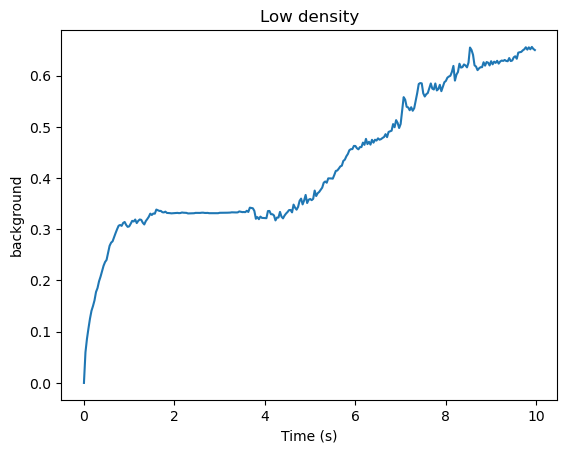

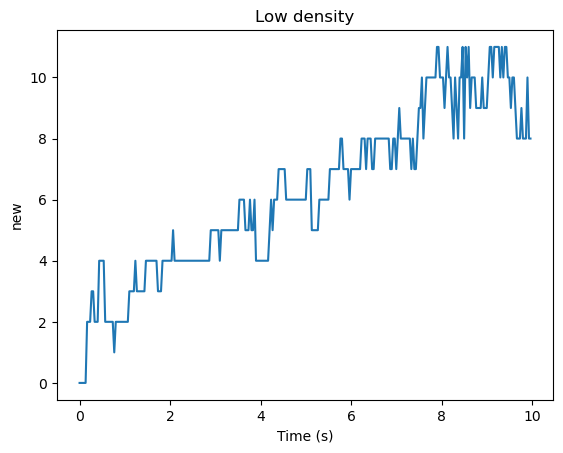

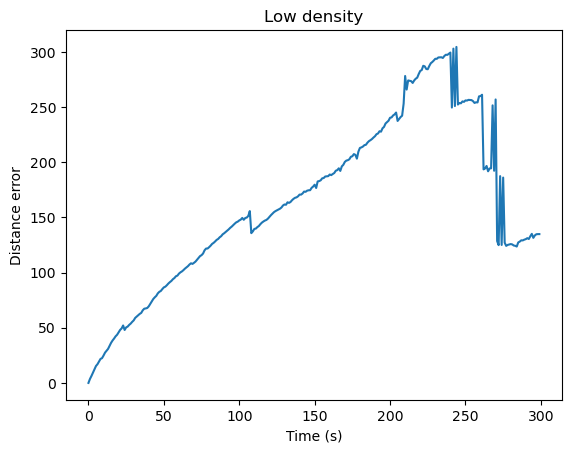

In [57]:
from corr_study.truthsetter import *
import pandas as pd
import seaborn as sns
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1000, time, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT)
df_low = pd.DataFrame.from_dict(dicts)
df_low["Time (s)"] = np.arange(time)/30

others_low = list(df_low.columns)
others_low.remove("new")
others_low.remove("background")
others_low.remove("Time (s)")
others_low.remove("mobile")
print(others_low)
sns.lineplot(data=df_low, x="Time (s)", y="background", legend=False)
plt.title("Low density")
plt.show()
sns.lineplot(data=df_low, x="Time (s)", y="new", legend=False)
plt.title("Low density")
plt.show()
sns.lineplot(data=df_low[others_low].sum(axis=1), legend=False)
plt.xlabel("Time (s)")
plt.ylabel("Distance error")
plt.title("Low density")
plt.show()

[109, 120, 164, 213, 225, 226, 256, 285, 300, 304, 310, 341, 342, 368, 375, 393, 395, 414, 425, 446, 474, 481, 483, 523, 537, 542, 553, 568, 569, 571, 576, 579, 598, 632, 638, 674]


/tmp/ipykernel_20481/1228358799.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="Time (s)", y="background", legend=False, palette=["r"])
/tmp/ipykernel_20481/1228358799.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_low, x="Time (s)", y="background", legend=False, palette=['g'])


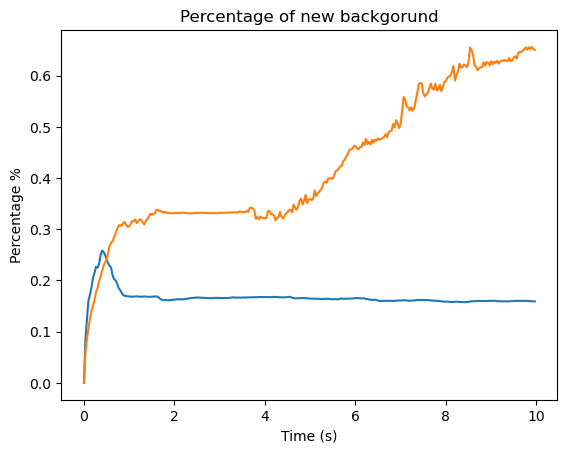

/tmp/ipykernel_20481/1228358799.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="Time (s)", y="new", legend=False, palette=["r"])
/tmp/ipykernel_20481/1228358799.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_low, x="Time (s)", y="new", legend=False, palette=['g'])


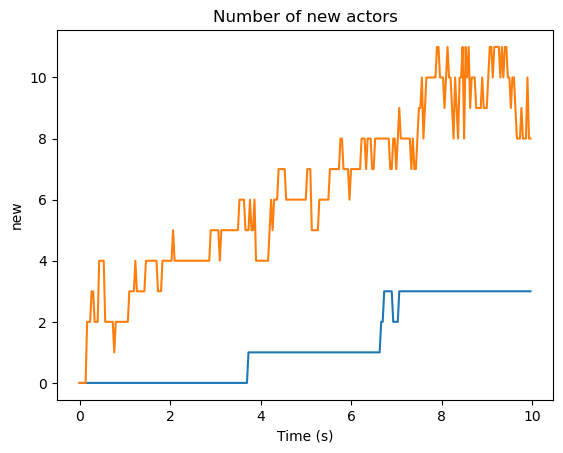

/tmp/ipykernel_20481/1228358799.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df[others].sum(axis=1), legend=False, palette=["r"])
/tmp/ipykernel_20481/1228358799.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_low[others_low].sum(axis=1), legend=False, palette=['g'])


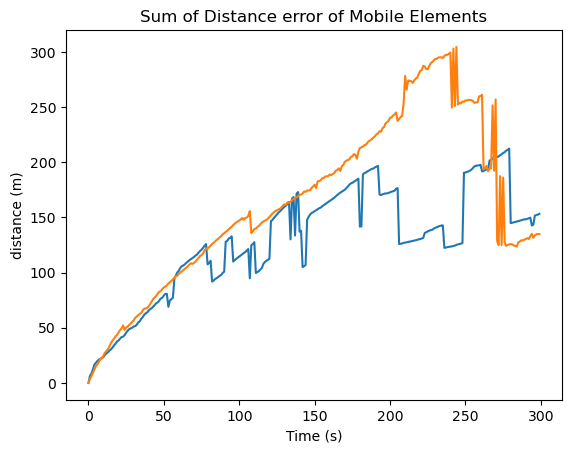

In [60]:
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 4413, time, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT)
df = pd.DataFrame.from_dict(dicts)
df["Time (s)"] = np.arange(time)/30
others = list(df.columns)
others.remove("new")
others.remove("background")
others.remove("Time (s)")
others.remove("mobile")
print(others)
sns.lineplot(data=df, x="Time (s)", y="background", legend=False, color='r')
sns.lineplot(data=df_low, x="Time (s)", y="background", legend=False, color='g')
plt.ylabel("Percentage %")
plt.title("Percentage of new backgorund")
plt.show()
sns.lineplot(data=df, x="Time (s)", y="new", legend=False, color='r')
sns.lineplot(data=df_low, x="Time (s)", y="new", legend=False, color='g')
plt.title("Number of new actors")
plt.show()
sns.lineplot(data=df[others].sum(axis=1), legend=False, color='r')
sns.lineplot(data=df_low[others_low].sum(axis=1), legend=False, color='g')
plt.xlabel("Time (s)")
plt.ylabel("distance (m)")
plt.title("Sum of Distance error of Mobile Elements")
plt.show()

100%|██████████| 299/299 [05:22<00:00,  1.08s/it]


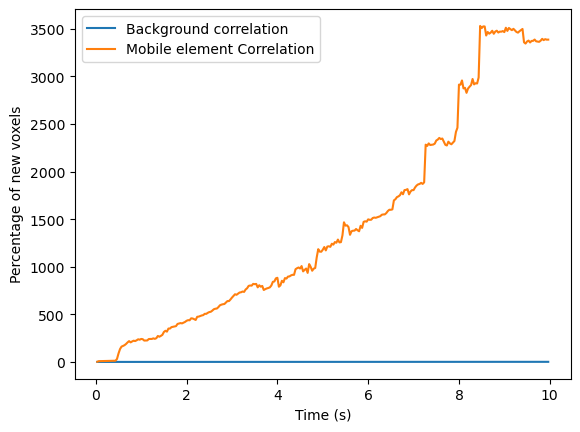

In [82]:
from tqdm import trange
m = tf.keras.models.load_model('network_miniUNet.h5')
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
back_correlation_low = []
mobile_correlation_low = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                                       m, 
                                                                                                       initial_transformation=previous_transformation,
                                                                                                       initial_centroids=previous_centroids)
    back_correlation_low.append(background)
    mobile_correlation_low.append(mobile)
fig, ax = plt.subplots(1,1)
bl, = ax.plot(np.arange(1,300)/30, back_correlation_low)
ml, = ax.plot(np.arange(1,300)/30, mobile_correlation_low)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Percentage of new voxels")
ax.legend([bl, ml],["Background correlation", "Mobile element Correlation"])

100%|██████████| 299/299 [05:42<00:00,  1.15s/it]


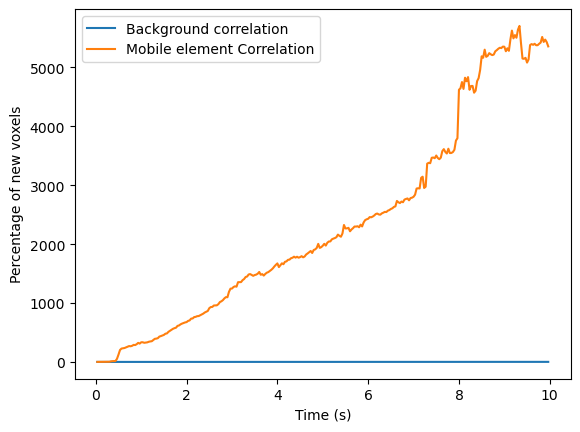

In [83]:
m = tf.keras.models.load_model('network_miniUNet.h5')
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
back_correlation_high = []
mobile_correlation_high = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                   m, 
                                                                                   initial_transformation=previous_transformation,
                                                                                   initial_centroids=previous_centroids)
    back_correlation_high.append(background)
    mobile_correlation_high.append(mobile)
fig, ax = plt.subplots(1,1)
bh, = ax.plot(np.arange(1,300)/30, back_correlation_high)
mh, = ax.plot(np.arange(1,300)/30, mobile_correlation_high)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Percentage of new voxels")
ax.legend([bh, mh],["Background correlation", "Mobile element Correlation"])

Text(0, 0.5, 'Distance of mobile objects')

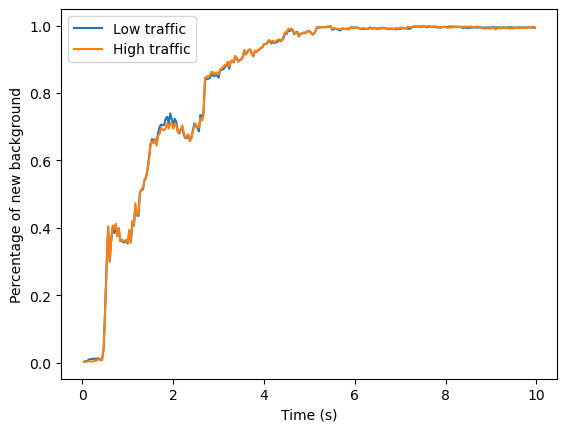

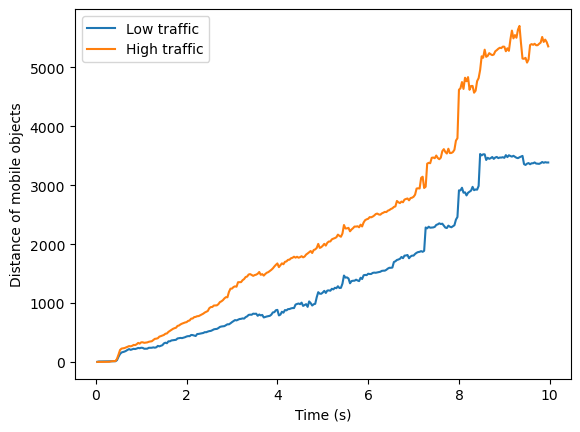

In [84]:
fig, ax = plt.subplots(1,1)
bl, = ax.plot(np.arange(1,300)/30, back_correlation_low)
bh, = ax.plot(np.arange(1,300)/30, back_correlation_high)
ax.set_ylabel("Percentage of new background")
ax.set_xlabel("Time (s)")
ax.legend([bl, bh],["Low traffic", "High traffic"])
fig, ax = plt.subplots(1,1)
ml, = ax.plot(np.arange(1,300)/30, mobile_correlation_low)
mh, = ax.plot(np.arange(1,300)/30, mobile_correlation_high)
ax.legend([ml, mh],["Low traffic", "High traffic"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Distance of mobile objects")
plt.show()

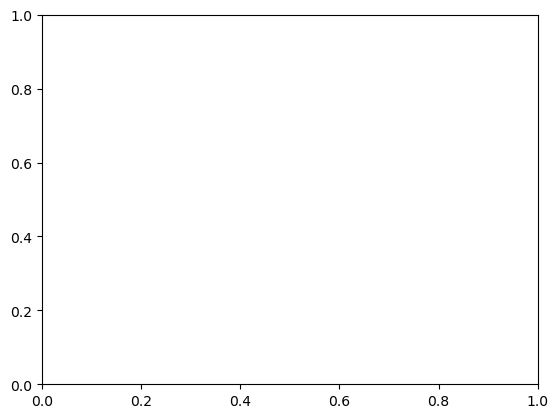

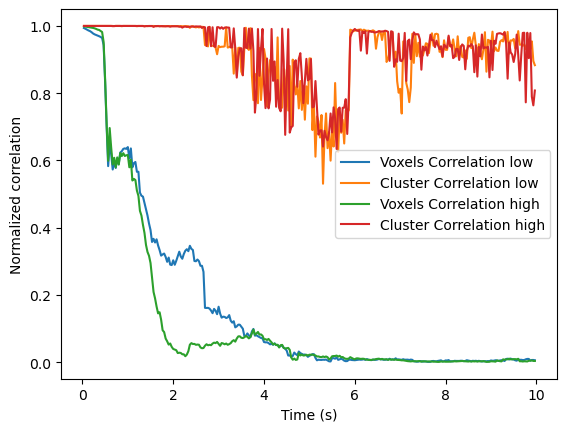

In [90]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation_low = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation_low.append(correla)
icp_cluster_correlation_low = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation_low.append(correla)
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation.append(correla)
icp_cluster_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation.append(correla)
fig, ax = plt.subplots(1,1)
ppl, = ax.plot(np.arange(1,300)/30, icp_correlation_low)
pcl, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation_low)
pp, = ax.plot(np.arange(1,300)/30, icp_correlation)
pc, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized correlation")
ax.legend([ppl, pcl, pp, pc],["Voxels Correlation low", "Cluster Correlation low", "Voxels Correlation high", "Cluster Correlation high"])
plt.show()

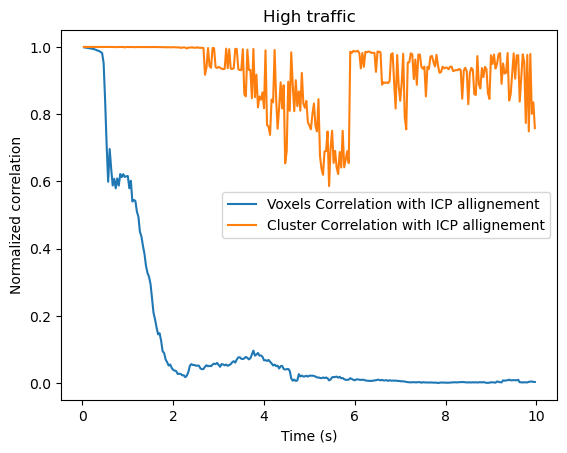

In [89]:
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation.append(correla)
icp_cluster_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation.append(correla)
fig, ax = plt.subplots(1,1)
pp, = ax.plot(np.arange(1,300)/30, icp_correlation)
pc, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation)
ax.set_title("High traffic")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized correlation")
ax.legend([pp, pc],["Voxels Correlation with ICP allignement", "Cluster Correlation with ICP allignement"])
plt.show()

In [6]:
from tqdm import trange
# 1000 4413
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1, time, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT)
df_low = pd.DataFrame.from_dict(dicts)
df_low["Time (s)"] = np.arange(time)/30

others_low = list(df_low.columns)
others_low.remove("new")
others_low.remove("background")
others_low.remove("Time (s)")
others_low.remove("mobile")

fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1, time, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT)
df = pd.DataFrame.from_dict(dicts)
df["Time (s)"] = np.arange(time)/30
others = list(df.columns)
others.remove("new")
others.remove("background")
others.remove("Time (s)")
others.remove("mobile")

m = tf.keras.models.load_model('network_miniUNet.h5')

pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
back_correlation_low = []
mobile_correlation_low = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                                       m, 
                                                                                                       initial_transformation=previous_transformation,
                                                                                                       initial_centroids=previous_centroids)
    back_correlation_low.append(background)
    mobile_correlation_low.append(mobile)

pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
back_correlation_high = []
mobile_correlation_high = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                   m, 
                                                                                   initial_transformation=previous_transformation,
                                                                                   initial_centroids=previous_centroids)
    back_correlation_high.append(background)
    mobile_correlation_high.append(mobile)

2023-03-17 09:15:30.064018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 09:15:30.067437: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
100%|██████████| 299/299 [05:06<00:00,  1.02s/it]


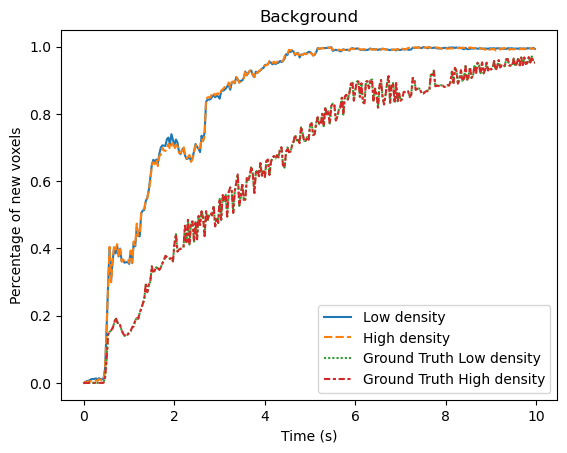

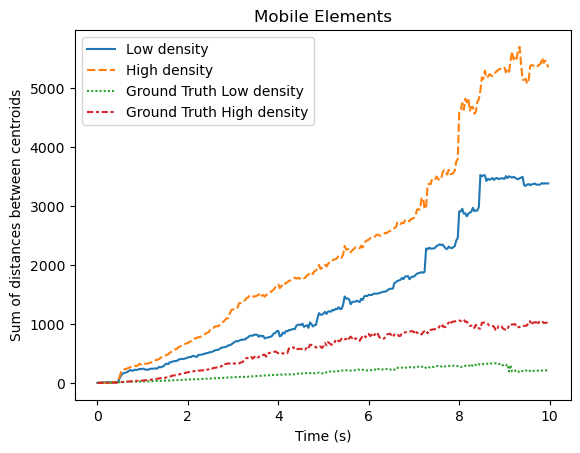

In [35]:
df_datas_back = [[0,] + back_correlation_low,
                 [0,] + back_correlation_high,
                 list(df_low["background"]),
                 list(df["background"])] 

df_datas_back = np.array(df_datas_back).T
df_datas_back = pd.DataFrame(df_datas_back, np.arange(300)/30, ["Low density", "High density", "Ground Truth Low density", "Ground Truth High density"])
sns.lineplot(df_datas_back, dashes=True)
plt.title("Background")
plt.ylabel("Percentage of new voxels")
plt.xlabel("Time (s)")
plt.show()

df_datas_mobile = [[0,] + mobile_correlation_low,
                   [0,] + mobile_correlation_high,
                   list(df_low[others_low].sum(axis=1)),
                   list(df[others].sum(axis=1))] 
df_datas_mobile = np.array(df_datas_mobile).T
df_datas_mobile = pd.DataFrame(df_datas_mobile, np.arange(300)/30, ["Low density", "High density", "Ground Truth Low density", "Ground Truth High density"])
sns.lineplot(df_datas_mobile, dashes=True)
plt.title("Mobile Elements")
plt.ylabel("Sum of distances between centroids")
plt.xlabel("Time (s)")
plt.show()

In [36]:
roba = {"df low":df_low,
        "df high": df,
        "back low": back_correlation_low,
        "back high": back_correlation_high,
        "mobile low": mobile_correlation_low,
        "mobile high": mobile_correlation_high}
with open('1.pickle', 'wb') as handle:
    pickle.dump(roba, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 299/299 [04:47<00:00,  1.04it/s]


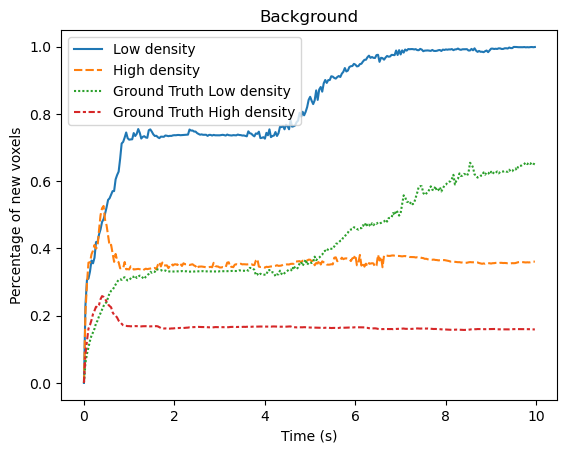

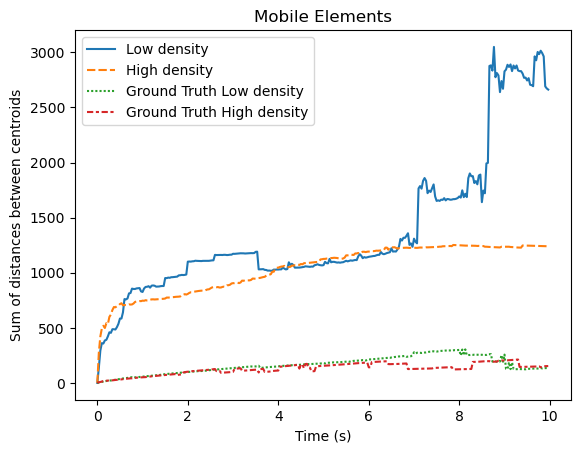

In [37]:
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1000, time, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT)
df_low = pd.DataFrame.from_dict(dicts)
df_low["Time (s)"] = np.arange(time)/30

others_low = list(df_low.columns)
others_low.remove("new")
others_low.remove("background")
others_low.remove("Time (s)")
others_low.remove("mobile")

fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 4413, time, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT)
df = pd.DataFrame.from_dict(dicts)
df["Time (s)"] = np.arange(time)/30
others = list(df.columns)
others.remove("new")
others.remove("background")
others.remove("Time (s)")
others.remove("mobile")

m = tf.keras.models.load_model('network_miniUNet.h5')

pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1000)
back_correlation_low = []
mobile_correlation_low = []
previous_transformation = None
previous_centroids = None
for i in trange(999+2, 999+301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                                       classifier=m, 
                                                                                                       initial_transformation=previous_transformation,
                                                                                                       initial_centroids=previous_centroids)
    back_correlation_low.append(background)
    mobile_correlation_low.append(mobile)

pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 4413)
back_correlation_high = []
mobile_correlation_high = []
previous_transformation = None
previous_centroids = None
for i in trange(4412+2, 4412+301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                   classifier=m, 
                                                                                   initial_transformation=previous_transformation,
                                                                                   initial_centroids=previous_centroids)
    back_correlation_high.append(background)
    mobile_correlation_high.append(mobile)

roba = {"df low":df_low,
        "df high": df,
        "back low": back_correlation_low,
        "back high": back_correlation_high,
        "mobile low": mobile_correlation_low,
        "mobile high": mobile_correlation_high}

with open('1000.pickle', 'wb') as handle:
    pickle.dump(roba, handle, protocol=pickle.HIGHEST_PROTOCOL)


df_datas_back = [[0,] + back_correlation_low,
                 [0,] + back_correlation_high,
                 list(df_low["background"]),
                 list(df["background"])] 

df_datas_back = np.array(df_datas_back).T
df_datas_back = pd.DataFrame(df_datas_back, np.arange(300)/30, ["Low density", "High density", "Ground Truth Low density", "Ground Truth High density"])
sns.lineplot(df_datas_back, dashes=True)
plt.title("Background")
plt.ylabel("Percentage of new voxels")
plt.xlabel("Time (s)")
plt.show()

df_datas_mobile = [[0,] + mobile_correlation_low,
                   [0,] + mobile_correlation_high,
                   list(df_low[others_low].sum(axis=1)),
                   list(df[others].sum(axis=1))] 
df_datas_mobile = np.array(df_datas_mobile).T
df_datas_mobile = pd.DataFrame(df_datas_mobile, np.arange(300)/30, ["Low density", "High density", "Ground Truth Low density", "Ground Truth High density"])
sns.lineplot(df_datas_mobile, dashes=True)
plt.title("Mobile Elements")
plt.ylabel("Sum of distances between centroids")
plt.xlabel("Time (s)")
plt.show()

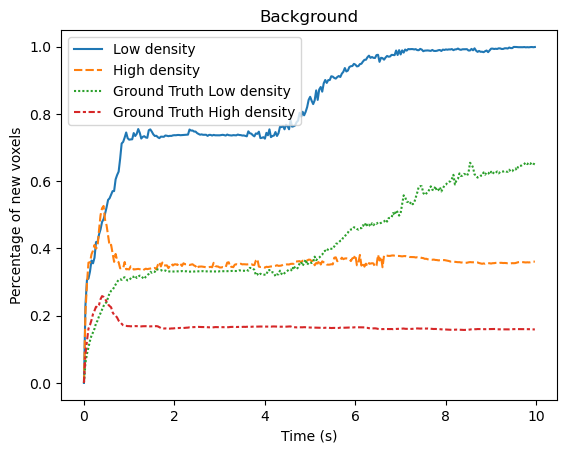

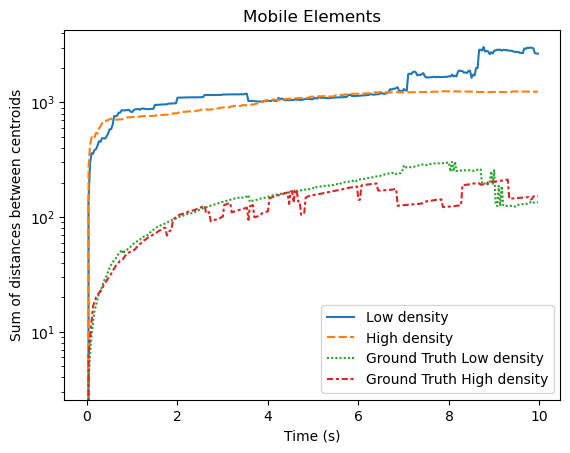

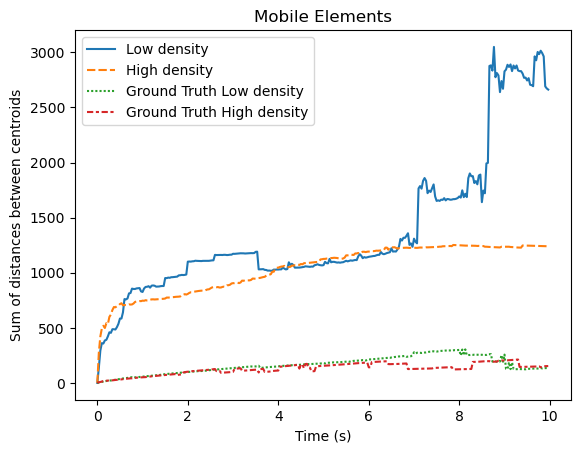

In [40]:
df_datas_back = [[0,] + back_correlation_low,
                 [0,] + back_correlation_high,
                 list(df_low["background"]),
                 list(df["background"])] 

df_datas_back = np.array(df_datas_back).T
df_datas_back = pd.DataFrame(df_datas_back, np.arange(300)/30, ["Low density", "High density", "Ground Truth Low density", "Ground Truth High density"])
sns.lineplot(df_datas_back, dashes=True)
plt.title("Background")
plt.ylabel("Percentage of new voxels")
plt.xlabel("Time (s)")
plt.show()

df_datas_mobile = [[0,] + mobile_correlation_low,
                   [0,] + mobile_correlation_high,
                   list(df_low[others_low].sum(axis=1)),
                   list(df[others].sum(axis=1))] 
df_datas_mobile = np.array(df_datas_mobile).T
df_datas_mobile = pd.DataFrame(df_datas_mobile, np.arange(300)/30, ["Low density", "High density", "Ground Truth Low density", "Ground Truth High density"])
sns.lineplot(df_datas_mobile, dashes=True)
plt.title("Mobile Elements")
plt.ylabel("Sum of distances between centroids")
plt.xlabel("Time (s)")
plt.yscale("log")
plt.show()
sns.lineplot(df_datas_mobile, dashes=True)
plt.title("Mobile Elements")
plt.ylabel("Sum of distances between centroids")
plt.xlabel("Time (s)")
plt.show()

In [77]:
from tqdm import trange
# 1000 4413
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1, time, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT)
df_low = pd.DataFrame.from_dict(dicts)
df_low["Time (s)"] = np.arange(time)/30

others_low = list(df_low.columns)
others_low.remove("new")
others_low.remove("background")
others_low.remove("Time (s)")
others_low.remove("mobile")

fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1, time, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT)
df = pd.DataFrame.from_dict(dicts)
df["Time (s)"] = np.arange(time)/30
others = list(df.columns)
others.remove("new")
others.remove("background")
others.remove("Time (s)")
others.remove("mobile")

pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
pcd_top.really_euristic_classifier()
back_correlation_low = []
mobile_correlation_low = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    pcd_top_compare.really_euristic_classifier()
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                                       initial_transformation=previous_transformation,
                                                                                                       initial_centroids=previous_centroids,
                                                                                                       voxel_size=1.0)
    back_correlation_low.append(background)
    mobile_correlation_low.append(mobile)

pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
pcd_top.really_euristic_classifier()
back_correlation_high = []
mobile_correlation_high = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    pcd_top_compare.really_euristic_classifier()
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                   initial_transformation=previous_transformation,
                                                                                   initial_centroids=previous_centroids,
                                                                                   voxel_size=1.0)
    back_correlation_high.append(background)
    mobile_correlation_high.append(mobile)

100%|██████████| 299/299 [00:57<00:00,  5.18it/s]


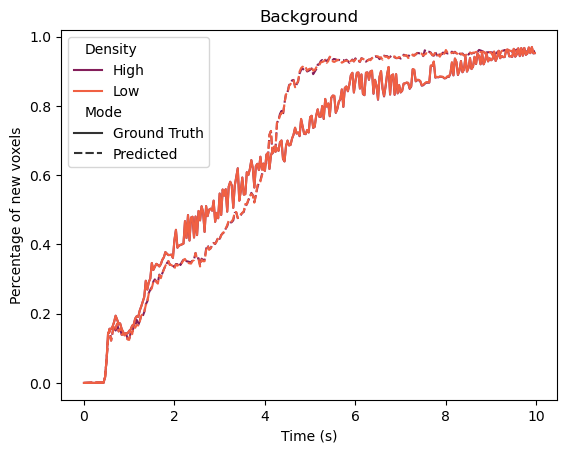

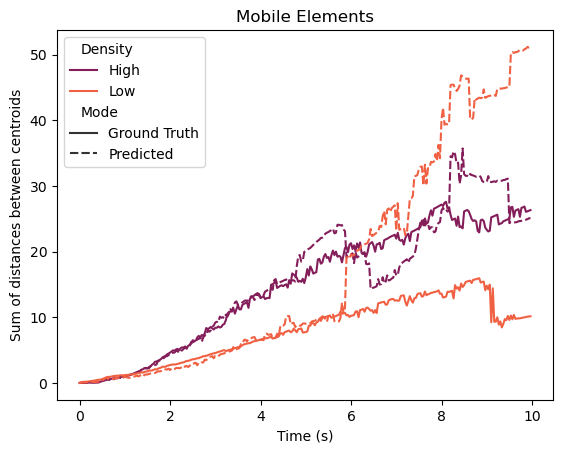

In [118]:
df_datas_back = [[0,] + back_correlation_low + [0,] + back_correlation_high + list(df_low["background"]) + list(df["background"]),
                 list(np.arange(300)/30) * 4] 
df_datas_back = np.array(df_datas_back).T
df_datas_back = pd.DataFrame(df_datas_back, columns=["Correlation", "Time"])
df_datas_back["Density"] = pd.Categorical(["Low",] * 300 + ["High",]* 300 + ["Low",] * 300 + ["High",]* 300) 
df_datas_back["Mode"] = pd.Categorical(["Predicted",] * 600 + ["Ground Truth",] * 600)
sns.lineplot(data=df_datas_back, x="Time", y="Correlation", dashes=True, hue="Density", style="Mode", palette="rocket")
plt.title("Background")
plt.ylabel("Percentage of new voxels")
plt.xlabel("Time (s)")
plt.show()

df_datas_mobile = [[0,] + mobile_correlation_low + [0,] + mobile_correlation_high + list(df_low[others_low].mean(axis=1)) + list(df[others].mean(axis=1)),
                   list(np.arange(300)/30) * 4] 
df_datas_mobile = np.array(df_datas_mobile).T
df_datas_mobile = pd.DataFrame(df_datas_mobile, columns=["Correlation", "Time"])
df_datas_mobile["Density"] = pd.Categorical(["Low",] * 300 + ["High",]* 300 + ["Low",] * 300 + ["High",]* 300) 
df_datas_mobile["Mode"] = pd.Categorical(["Predicted",] * 600 + ["Ground Truth",] * 600)
sns.lineplot(data=df_datas_mobile, x="Time", y="Correlation", dashes=True, hue="Density", style="Mode", palette="rocket")
plt.title("Mobile Elements")
plt.ylabel("Sum of distances between centroids")
plt.xlabel("Time (s)")
plt.show()

In [119]:
from tqdm import trange
# 1000 4413
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1000, time, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT)
df_low = pd.DataFrame.from_dict(dicts)
df_low["Time (s)"] = np.arange(time)/30

others_low = list(df_low.columns)
others_low.remove("new")
others_low.remove("background")
others_low.remove("Time (s)")
others_low.remove("mobile")

fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 4413, time, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT)
df = pd.DataFrame.from_dict(dicts)
df["Time (s)"] = np.arange(time)/30
others = list(df.columns)
others.remove("new")
others.remove("background")
others.remove("Time (s)")
others.remove("mobile")

pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1000)
pcd_top.really_euristic_classifier()
back_correlation_low = []
mobile_correlation_low = []
previous_transformation = None
previous_centroids = None
for i in trange(999+2, 999+301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    pcd_top_compare.really_euristic_classifier()
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                                       initial_transformation=previous_transformation,
                                                                                                       initial_centroids=previous_centroids,
                                                                                                       voxel_size=1.0)
    back_correlation_low.append(background)
    mobile_correlation_low.append(mobile)

pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 4413)
pcd_top.really_euristic_classifier()
back_correlation_high = []
mobile_correlation_high = []
previous_transformation = None
previous_centroids = None
for i in trange(4412 + 2, 4412 + 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    pcd_top_compare.really_euristic_classifier()
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                   initial_transformation=previous_transformation,
                                                                                   initial_centroids=previous_centroids,
                                                                                   voxel_size=1.0)
    back_correlation_high.append(background)
    mobile_correlation_high.append(mobile)

100%|██████████| 299/299 [00:34<00:00,  8.59it/s]


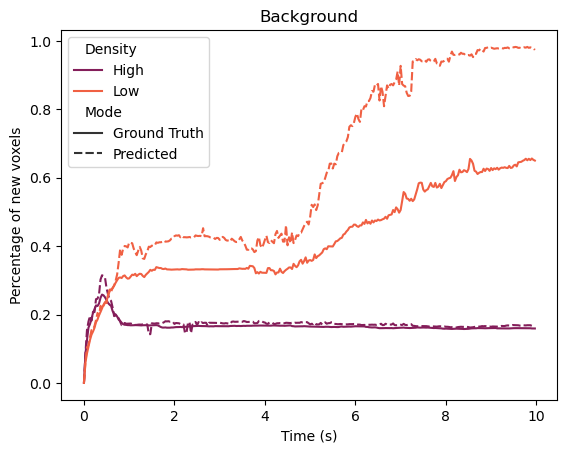

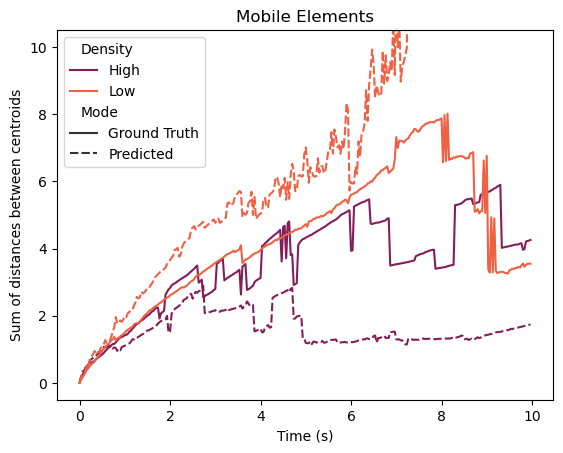

In [121]:
df_datas_back = [[0,] + back_correlation_low + [0,] + back_correlation_high + list(df_low["background"]) + list(df["background"]),
                 list(np.arange(300)/30) * 4] 
df_datas_back = np.array(df_datas_back).T
df_datas_back = pd.DataFrame(df_datas_back, columns=["Correlation", "Time"])
df_datas_back["Density"] = pd.Categorical(["Low",] * 300 + ["High",]* 300 + ["Low",] * 300 + ["High",]* 300) 
df_datas_back["Mode"] = pd.Categorical(["Predicted",] * 600 + ["Ground Truth",] * 600)
sns.lineplot(data=df_datas_back, x="Time", y="Correlation", dashes=True, hue="Density", style="Mode", palette="rocket")
plt.title("Background")
plt.ylabel("Percentage of new voxels")
plt.xlabel("Time (s)")
plt.show()

df_datas_mobile = [[0,] + mobile_correlation_low + [0,] + mobile_correlation_high + list(df_low[others_low].mean(axis=1)) + list(df[others].mean(axis=1)),
                   list(np.arange(300)/30) * 4] 
df_datas_mobile = np.array(df_datas_mobile).T
df_datas_mobile = pd.DataFrame(df_datas_mobile, columns=["Correlation", "Time"])
df_datas_mobile["Density"] = pd.Categorical(["Low",] * 300 + ["High",]* 300 + ["Low",] * 300 + ["High",]* 300) 
df_datas_mobile["Mode"] = pd.Categorical(["Predicted",] * 600 + ["Ground Truth",] * 600)
sns.lineplot(data=df_datas_mobile, x="Time", y="Correlation", dashes=True, hue="Density", style="Mode", palette="rocket")
plt.title("Mobile Elements")
plt.ylabel("Sum of distances between centroids")
plt.xlabel("Time (s)")
plt.ylim([-0.5, 10.5])
plt.show()

In [26]:
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 300)
pcd_top.really_euristic_classifier()
centroids = [pcd_top.centroids]
back_correlation_high = []
mobile_correlation_high = []
previous_transformation = None
previous_centroids = None
for i in trange(301, 350):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    pcd_top_compare.really_euristic_classifier()
    _, _, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                   initial_transformation=previous_transformation,
                                                                                   initial_centroids=previous_centroids,
                                                                                   voxel_size=1.0)
    centroids.append(previous_centroids)

100%|██████████| 49/49 [00:08<00:00,  5.61it/s]


In [27]:
centroids_pcd = []
cmap = sns.color_palette("hsv", n_colors=centroids[0].shape[0])
print(cmap)
for c in centroids:
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(c)
    pcd.colors = o3d.utility.Vector3dVector(cmap)
    centroids_pcd.append(pcd)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_top.data)
pcd.paint_uniform_color([0, 0, 0])
centroids_pcd.append(pcd)
o3d.visualization.draw_geometries(centroids_pcd)

[(1.0, 0.06948536360301065, 0.0), (1.0, 0.16213251507369153, 0.0), (1.0, 0.2547796665443724, 0.0), (1.0, 0.34742681801505326, 0.0), (1.0, 0.4400739694857342, 0.0), (1.0, 0.532721120956415, 0.0), (1.0, 0.6253682724270958, 0.0), (1.0, 0.7180154238977768, 0.0), (1.0, 0.8106625753684576, 0.0), (1.0, 0.9033097268391386, 0.0), (0.9805143738967269, 0.9764712522065463, 0.0), (0.9113959702194997, 1.0, 0.0), (0.8187488187488188, 1.0, 0.0), (0.726101667278138, 1.0, 0.0), (0.633454515807457, 1.0, 0.0), (0.5408073643367761, 1.0, 0.0), (0.4713220007337658, 1.0, 0.0), (0.3786748492630846, 1.0, 0.0), (0.2860276977924041, 1.0, 0.0), (0.19338054632172286, 1.0, 0.0), (0.10073339485104227, 1.0, 0.0), (0.0235287477934537, 1.0, 0.015442504413092598), (0.0, 1.0, 0.08456076910733497), (0.0, 1.0, 0.1772073369040554), (0.0, 1.0, 0.2698539047007752), (0.0, 1.0, 0.3625004724974957), (0.0, 1.0, 0.45514704029421543), (0.0, 1.0, 0.547793608090936), (0.0, 1.0, 0.6404401758876557), (0.0, 1.0, 0.7330867436843761), (0.0

# Object Tracking

In [1]:
from corr_study.sort.sort import *

In [30]:
floor_level = -1.26
max_height = 2.2
points = [
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [1, 1, 0],
    [0, 0, 1],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 1],
]
lines = [
    [0, 1],
    [0, 2],
    [1, 3],
    [2, 3],
    [4, 5],
    [4, 6],
    [5, 7],
    [6, 7],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7],
]

colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([line_set])
mot_tracker = Sort()
for i in range(1, 11):
    pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    pcd_top.really_euristic_classifier()
    uni = np.unique(pcd_top.isMobile)
    det = []
    for i in range(1,len(uni)):
        bounding_box = [np.min(pcd_top.data[pcd_top.isMobile == i, 0]),
                        np.min(pcd_top.data[pcd_top.isMobile == i, 1]),
                        np.max(pcd_top.data[pcd_top.isMobile == i, 0]),
                        np.max(pcd_top.data[pcd_top.isMobile == i, 1]),
                        1]
        det.append(bounding_box)
    track_bbs_ids = mot_tracker.update(np.array(det))
    print(track_bbs_ids[:,4])
    print(mot_tracker.trackers[0].kf.x)

/home/filo/thesis/pqos-correlation/corr_study/sort/sort.py:77: RuntimeWarning: invalid value encountered in double_scalars
  r = w / float(h)


[1639. 1638. 1637. 1636. 1635. 1634. 1633. 1632. 1631. 1630. 1629. 1628.
 1627. 1626. 1625. 1624. 1623. 1622. 1621. 1620. 1619. 1618. 1617. 1616.
 1615. 1614. 1613. 1612. 1611. 1610.]
[[ -8.59264636]
 [-86.38740921]
 [ 10.75485342]
 [  0.93374944]
 [  0.        ]
 [  0.        ]
 [  0.        ]]
[1644. 1643. 1642. 1641. 1640. 1639. 1638. 1637. 1636. 1635. 1633. 1631.
 1630. 1628. 1626. 1625. 1624. 1623. 1622. 1621. 1620. 1619. 1618. 1617.
 1616. 1615. 1614. 1613. 1612. 1611. 1610.]
[[-8.59268546e+00]
 [-8.63873520e+01]
 [ 1.07549742e+01]
 [ 9.33743938e-01]
 [-3.90537824e-05]
 [ 5.71518767e-05]
 [ 1.20633086e-04]]
[1650. 1649. 1648. 1647. 1646. 1645. 1639. 1638. 1637. 1636. 1635. 1633.
 1631. 1630. 1628. 1626. 1625. 1624. 1623. 1622. 1621. 1620. 1619. 1618.
 1617. 1616. 1615. 1614. 1613. 1612. 1611. 1610.]
[[-8.59273353e+00]
 [-8.63873235e+01]
 [ 1.07551089e+01]
 [ 9.33741757e-01]
 [-4.63852294e-05]
 [ 3.38722948e-05]
 [ 1.29004636e-04]]
[1639. 1638. 1637. 1636. 1635. 1633. 1631. 1630. 

# Chamfer Distance

In [14]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
cd_low_50_pre = []
previous_transformation = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cd, previous_transformation = pcd_top.align_and_compute_cd(pcd_top_compare,
                                      mode=selmaPointCloud.ICP_REGISTRATION,
                                      init_transform=previous_transformation,
                                      remove_far_points=selmaPointCloud.PRE_REGISTRATION
                                      )
    cd_low_50_pre.append(cd)

pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
cd_high_50_pre = []
previous_transformation = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cd, previous_transformation = pcd_top.align_and_compute_cd(pcd_top_compare,
                                      mode=selmaPointCloud.ICP_REGISTRATION,
                                      init_transform=previous_transformation,
                                      remove_far_points=selmaPointCloud.PRE_REGISTRATION
                                      )
    cd_high_50_pre.append(cd)

pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
cd_low_50_post = []
previous_transformation = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cd, previous_transformation = pcd_top.align_and_compute_cd(pcd_top_compare,
                                      mode=selmaPointCloud.ICP_REGISTRATION,
                                      init_transform=previous_transformation,
                                      remove_far_points=selmaPointCloud.POST_REGISTRATION
                                      )
    cd_low_50_post.append(cd)

pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
cd_high_50_post = []
previous_transformation = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cd, previous_transformation = pcd_top.align_and_compute_cd(pcd_top_compare,
                                      mode=selmaPointCloud.ICP_REGISTRATION,
                                      init_transform=previous_transformation,
                                      remove_far_points=selmaPointCloud.POST_REGISTRATION
                                      )
    cd_high_50_post.append(cd)

100%|██████████| 299/299 [01:02<00:00,  4.77it/s]


In [15]:
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
cds_gt_low_50 = find_truth_cd(fp, 1, 300, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT)
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
cds_gt_high_50 = find_truth_cd(fp, 1, 300, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT)
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
cds_gt_low_1000 = find_truth_cd(fp, 1, 300, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=1000)
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
cds_gt_high_1000 = find_truth_cd(fp, 1, 300, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=1000)

100%|██████████| 299/299 [00:41<00:00,  7.26it/s]


<class 'list'>
<class 'list'>
<class 'list'>


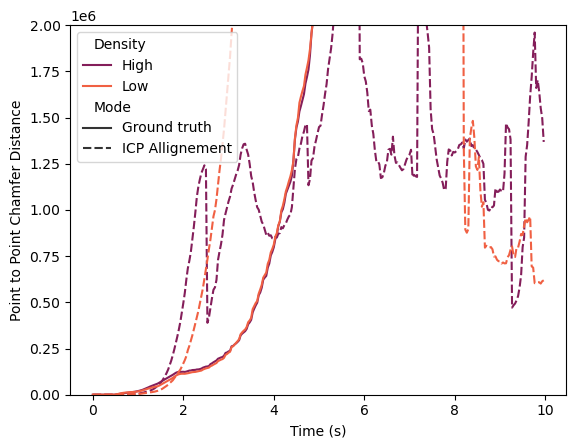

In [19]:
print(type(cds_gt_low_50))
print(type(cd_low_50_pre))
print(type(cd_low_50_pre))

dds = np.array([0,] + cds_gt_low_50 + [0,] + cds_gt_high_50  + [0,] + cd_low_50_post + [0,] + cd_high_50_post)
df_datas_back = [dds,
                 np.tile(np.arange(300)/30, 4)] 
df_datas_back = np.array(df_datas_back)
df_datas_back = df_datas_back.T
df_datas_back = pd.DataFrame(df_datas_back, columns=["Chamfer Distance", "Time"])
df_datas_back["Density"] = pd.Categorical((["Low",] * 300 + ["High",]* 300) * 2) 
df_datas_back["Mode"] = pd.Categorical(["Ground truth",] * 600 + ["ICP Allignement",] * 600)
sns.lineplot(data=df_datas_back, x="Time", y="Chamfer Distance", dashes=True, hue="Density", style="Mode", palette="rocket")
plt.ylabel("Point to Point Chamfer Distance")
plt.xlabel("Time (s)")
plt.ylim([-0.5, 2000000])
plt.show()

In [20]:
fp_low = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
fp_high = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
time_delay = 300
data = []
distances = []
for dist in np.arange(10,130,20):
    print("Computing for max_distance =", dist)
    cds_gt_low = find_truth_cd(fp_low, 1, time_delay, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=dist)
    cds_gt_high = find_truth_cd(fp_high, 1, time_delay, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=dist)
    data += [0]
    data += cds_gt_low
    data += [0]
    data += cds_gt_high
    distances += ([dist,] * (time_delay*2))
    

Computing for max_distance = 10


100%|██████████| 299/299 [00:26<00:00, 11.08it/s]


Computing for max_distance = 30


100%|██████████| 299/299 [00:34<00:00,  8.77it/s]


Computing for max_distance = 50


100%|██████████| 299/299 [00:35<00:00,  8.42it/s]


Computing for max_distance = 70


100%|██████████| 299/299 [00:36<00:00,  8.16it/s]


Computing for max_distance = 90


100%|██████████| 299/299 [00:39<00:00,  7.66it/s]


Computing for max_distance = 110


100%|██████████| 299/299 [00:39<00:00,  7.59it/s]


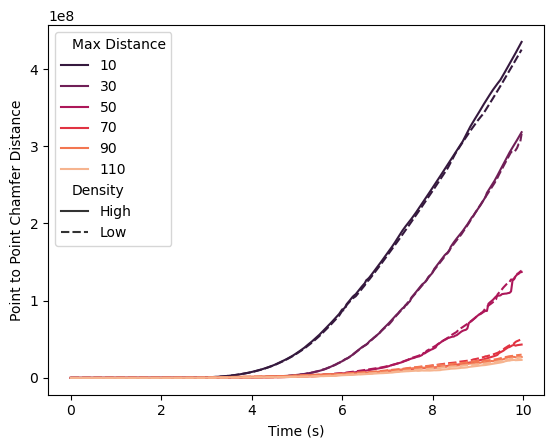

In [22]:
n_magic_rep = len(np.arange(10,130,20))

df_datas_back = [data,
                 np.tile(np.arange(time_delay)/30, n_magic_rep*2)] 
df_datas_back = np.array(df_datas_back)
df_datas_back = df_datas_back.T
df_datas_back = pd.DataFrame(df_datas_back, columns=["Chamfer Distance", "Time"])
df_datas_back["Density"] = pd.Categorical((["Low",] * time_delay + ["High",]* time_delay) * n_magic_rep) 
df_datas_back["Max Distance"] = pd.Categorical(distances)
sns.lineplot(data=df_datas_back, x="Time", y="Chamfer Distance", dashes=True, hue="Max Distance", style="Density", palette="rocket")
plt.ylabel("Point to Point Chamfer Distance")
plt.xlabel("Time (s)")
plt.show()

In [ ]:
def do_it_for_tot(tot, max_distance):
    pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
    cd_high_50_post = []
    previous_transformation = None
    for i in trange(2, tot+1):
        pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
        cd, previous_transformation = pcd_top.align_and_compute_cd(pcd_top_compare,
                                        mode=selmaPointCloud.ICP_REGISTRATION,
                                        init_transform=previous_transformation,
                                        remove_far_points=selmaPointCloud.POST_REGISTRATION,
                                        max_distance=max_distance
                                        )
        cd_high_50_post.append(cd)
    return cd_high_50_post

In [45]:
fp_high = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
time_delay = 300
data_bis = []
distances_bis = []
for dist in np.arange(10,130,20):
    print("Computing for max_distance =", dist)
    cds_gt_high = find_truth_cd(fp_high, 1, time_delay, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=dist)
    cds_icp_high = do_it_for_tot(time_delay, dist)
    data_bis += [0]
    data_bis += cds_gt_high
    data_bis += [0]
    data_bis += cds_icp_high
    distances_bis += ([dist,] * (time_delay*2))

Computing for max_distance = 10


100%|██████████| 299/299 [00:49<00:00,  6.07it/s]


Computing for max_distance = 30


100%|██████████| 299/299 [00:54<00:00,  5.49it/s]


Computing for max_distance = 50


100%|██████████| 299/299 [00:57<00:00,  5.22it/s]


Computing for max_distance = 70


100%|██████████| 299/299 [00:58<00:00,  5.07it/s]


Computing for max_distance = 90


100%|██████████| 299/299 [01:00<00:00,  4.92it/s]


Computing for max_distance = 110


100%|██████████| 299/299 [01:01<00:00,  4.85it/s]


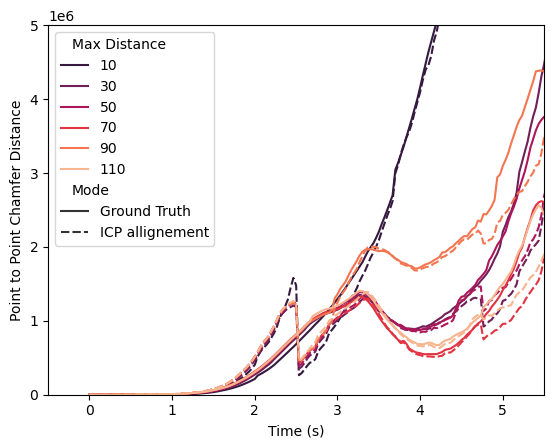

In [83]:
n_magic_rep = len(np.arange(10,130,20))

df_datas_back = [data_bis,
                 np.tile(np.arange(time_delay)/30, n_magic_rep*2)] 
df_datas_back = np.array(df_datas_back)
df_datas_back = df_datas_back.T
df_datas_back = pd.DataFrame(df_datas_back, columns=["Chamfer Distance", "Time"])
df_datas_back["Mode"] = pd.Categorical((["Ground Truth",] * time_delay + ["ICP allignement",]* time_delay) * n_magic_rep) 
df_datas_back["Max Distance"] = pd.Categorical(distances_bis)
sns.lineplot(data=df_datas_back, x="Time", y="Chamfer Distance", dashes=True, hue="Max Distance", style="Mode", palette="rocket")
plt.ylabel("Point to Point Chamfer Distance")
plt.ylim((-0.5, 5000000))
plt.xlim((-0.5, 5.5))
plt.xlabel("Time (s)")
plt.show()

In [34]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
cd_low_50_post = []
previous_transformation = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cd = pcd_top.align_and_compute_cd(pcd_top_compare,
                                      mode=selmaPointCloud.NOTHING,
                                      init_transform=previous_transformation,
                                      remove_far_points=selmaPointCloud.NO
                                      )
    cd_low_50_post.append(cd)

pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
cd_high_50_post = []
previous_transformation = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cd = pcd_top.align_and_compute_cd(pcd_top_compare,
                                      mode=selmaPointCloud.NOTHING,
                                      init_transform=previous_transformation,
                                      remove_far_points=selmaPointCloud.NO
                                      )
    cd_high_50_post.append(cd)

100%|██████████| 299/299 [00:28<00:00, 10.54it/s]


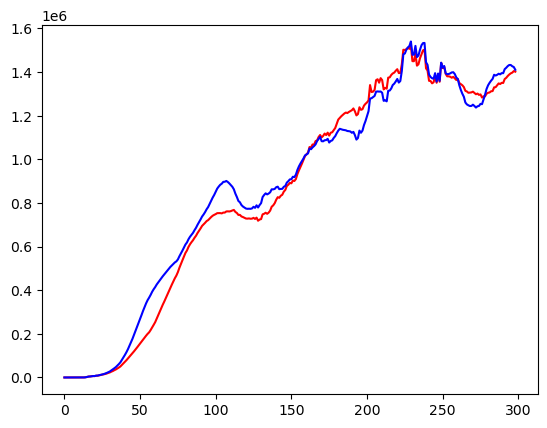

In [36]:
fig, ax = plt.subplots(1,1)
ax.plot(cd_low_50_post, c="r")
ax.plot(cd_high_50_post, c="b")

In [3]:
fp_high = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
time_delay = 300
data_tris = []
distances_tris = []
for dist in np.arange(10,130,20):
    print("Computing for max_distance =", dist)
    cds_gt_high = find_truth_cd_matching_ball(fp_high, 1, time_delay, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=dist)
    data_tris += [0]
    data_tris += cds_gt_high
    distances_tris += ([dist,] * (time_delay))

Computing for max_distance = 10


100%|██████████| 299/299 [00:27<00:00, 10.93it/s]


Computing for max_distance = 30


100%|██████████| 299/299 [00:41<00:00,  7.27it/s]


Computing for max_distance = 50


100%|██████████| 299/299 [00:47<00:00,  6.31it/s]


Computing for max_distance = 70


100%|██████████| 299/299 [00:51<00:00,  5.82it/s]


Computing for max_distance = 90


100%|██████████| 299/299 [00:55<00:00,  5.37it/s]


Computing for max_distance = 110


100%|██████████| 299/299 [00:56<00:00,  5.26it/s]


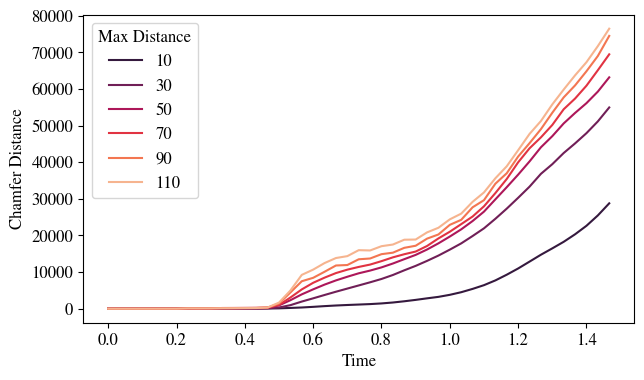

In [4]:
n_magic_rep = len(np.arange(10,130,20))

df_datas_back = [data_tris,
                 np.tile(np.arange(time_delay)/30, n_magic_rep)] 
df_datas_back = np.array(df_datas_back)
df_datas_back = df_datas_back.T
df_datas_back = pd.DataFrame(df_datas_back, columns=["Chamfer Distance", "Time"])
# df_datas_back["Mode"] = pd.Categorical((["Ground Truth",] * time_delay + ["ICP allignement",]* time_delay) * n_magic_rep) 
df_datas_back["Max Distance"] = pd.Categorical(distances_tris)
fig = plt.figure()
ax = fig.add_subplot(111)
df_datas_back_zoom = df_datas_back[df_datas_back["Time"] < 1.5]
sns.lineplot(data=df_datas_back_zoom, x="Time", y="Chamfer Distance", dashes=True, hue="Max Distance", palette="rocket", errorbar=None, ax=ax)

plt.savefig("output/latexplot/cd_high_t3_correctposition_zoom_.png")
tikzplotlib.save("output/latexplot/cd_high_t3_correctposition_zoom_.tex")
plt.show()

In [44]:
fp_high = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
time_delay = 60
data_quater = []
scenario_quater = []
for bb, scenario in zip(["/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5",
                         "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3medium/ClearSunset/BBOX.hdf5",
                         "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"], 
                        ["t3low",
                         "t3medium",
                         "t3high"]) :
    print("Computing scenario =", scenario)
    cds_gt_high = find_truth_cd_matching_ball(bb, 1, time_delay, dataset, scenario,  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=20)
    data_quater += [0]
    data_quater += cds_gt_high
    scenario_quater += ([scenario,] * (time_delay))

Computing scenario = t3low


100%|██████████| 59/59 [00:02<00:00, 27.27it/s]


(array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58]),)
([3.6901670913871065, 7.628651624943857, 11.856756149300164, 17.79354605019946, 23.27352866022926, 31.498185841252244, 39.7472362076771, 50.2249458878531, 61.042340713126364, 72.61705759859021, 88.19836236587008, 105.97687643932315, 127.08323129346962, 153.51058771361141, 175.86737939711062, 207.31082897232497, 246.64378061813773, 294.0712211217691, 335.9160744250869, 406.4575541697459, 504.8819804884953, 621.0624970671122, 773.8160790609991, 971.0034527548293, 1221.0641681874354], 25)
Computing scenario = t3medium


100%|██████████| 59/59 [00:02<00:00, 27.02it/s]


(array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]),)
([0.6489714868192484, 1.516639655191928, 2.8985623150675663, 4.868833697193158, 7.566737337574235, 10.934753929202474, 15.15267333945204, 19.85332250585907, 24.45507604608512, 29.762777142665673, 35.66056397420196, 41.47408086701951, 48.52655030223505, 55.80956156140053, 65.8078258701821, 74.54923831264759, 88.69612113002809, 99.83295394348903, 119.83764167737986, 146.45152317286542, 184.37304445240522, 246.4720968684386, 339.6459973948456, 468.19488265972126, 639.9170185014422, 870.2834868012476, 1134.590905709128], 27)
Computing scenario = t3high


100%|██████████| 59/59 [00:02<00:00, 24.09it/s]


(array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58]),)
([0.2021369560032188, 0.5591825171860083, 0.9440466823148608, 1.410958177907201, 2.1252260261256772, 3.3426754767504416, 4.854689666872835, 7.651537778167602, 11.624403175578827, 17.068556665370764, 23.846888214829605, 33.39789637534402, 45.032646089565134, 61.45529279752231, 86.3641937642918, 122.7569175897151, 161.50406532521419, 212.64741351483593, 272.99363233377466, 360.86099331357127, 479.20658580864233, 642.5604340513818, 862.1894707452775, 1133.2944848214865], 24)


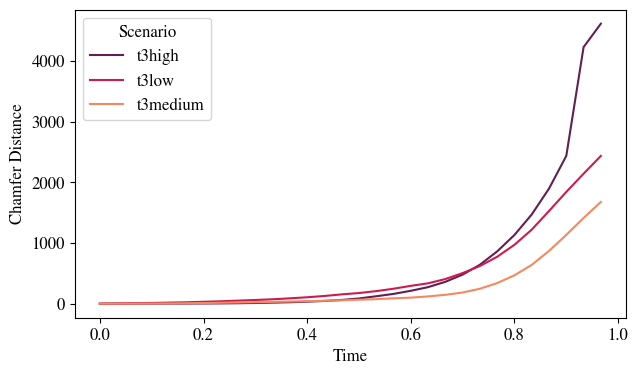

In [148]:
n_magic_rep = 3

df_datas_back = [data_quater,
                 np.tile(np.arange(time_delay)/30, n_magic_rep)] 
df_datas_back = np.array(df_datas_back)
df_datas_back = df_datas_back.T
df_datas_back = pd.DataFrame(df_datas_back, columns=["Chamfer Distance", "Time"])
# df_datas_back["Mode"] = pd.Categorical((["Ground Truth",] * time_delay + ["ICP allignement",]* time_delay) * n_magic_rep) 
df_datas_back["Scenario"] = pd.Categorical(scenario_quater)
fig = plt.figure()
ax = fig.add_subplot(111)
df_datas_back_zoom = df_datas_back[df_datas_back["Time"] < 1]
sns.lineplot(data=df_datas_back_zoom, x="Time", y="Chamfer Distance", dashes=True, hue="Scenario", palette="rocket", errorbar=None, ax=ax)

plt.savefig("output/latexplot/cd_correctposition_zoom.png")
tikzplotlib.save("output/latexplot/cd_correctposition_zoom.tex")
plt.show()

In [166]:
pbar.close()

  7%|▋         | 243/3254 [00:12<02:34, 19.55it/s]


In [167]:
time_delay = 60
data_penta = []
cd_penta = []
scenario_penta = []
scenario_cd_penta = []
for bb, scenario in zip(["/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5",
                         "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3medium/ClearSunset/BBOX.hdf5",
                         "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"], 
                        ["t3low",
                         "t3medium",
                         "t3high"]) :
    print("Computing scenario =", scenario)
    sim_length = dataset.get_measurement_series_length_TLC(scenario, Weather.Clear, Time.Sunset, Sensor.LT)
    i = 1
    i_trans = [1]
    pbar = tqdm(total=sim_length-1)
    pbar.update(1)
    while i < sim_length-1:
        cds, i_new = find_next_transmission(bb, i, dataset, scenario,  Weather.Clear, Time.Sunset, Sensor.LT, max_distance=20, max_cd=10000)
        cd_penta += [0]
        cd_penta += cds[:-1]
        scenario_cd_penta += [scenario,] * len(cds)
        pbar.update(i_new - i)
        i = i_new 
        i_trans += [i]
    print(len(scenario_cd_penta))
    pbar.close()
    a = list(np.diff(i_trans))
    data_penta.extend(a) 
    scenario_penta += [scenario,] * len(a)

Computing scenario = t3low


100%|██████████| 3254/3254 [02:47<00:00, 19.40it/s]


3253
Computing scenario = t3medium


100%|██████████| 3254/3254 [02:47<00:00, 19.37it/s]


6506
Computing scenario = t3high


100%|██████████| 5372/5372 [04:30<00:00, 19.83it/s]

11877


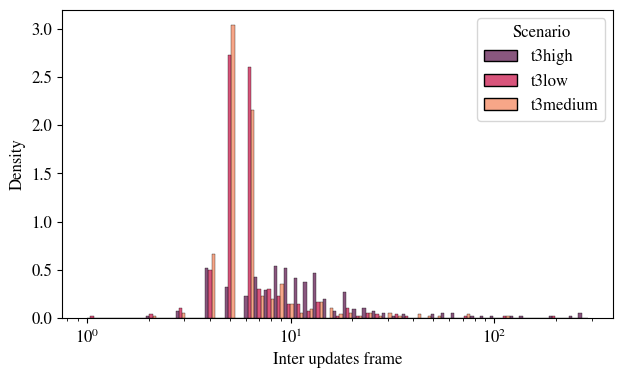

In [168]:
df_inter_transmission = [data_penta] 
df_inter_transmission = np.array(df_inter_transmission)
df_inter_transmission = df_inter_transmission.T
df_inter_transmission = pd.DataFrame(df_inter_transmission, columns=["Inter updates frame"])
# df_inter_transmission["Mode"] = pd.Categorical((["Ground Truth",] * time_delay + ["ICP allignement",]* time_delay) * n_magic_rep) 
df_inter_transmission["Scenario"] = pd.Categorical(scenario_penta)
fig = plt.figure()
ax = fig.add_subplot(111)
# df_inter_transmission_zoom = df_inter_transmission[df_inter_transmission["Time"] < 1]
sns.histplot(data=df_inter_transmission, x="Inter updates frame", hue="Scenario",ax=ax,stat='density', multiple="dodge", palette="rocket", log_scale=True)

plt.savefig("output/latexplot/hist_n_retr.png")
tikzplotlib.save("output/latexplot/hist_n_retr.tex")
plt.show()

In [169]:
print("Low traffic average intertransmission time", df_inter_transmission[df_inter_transmission["Scenario"] == "t3low"]["Inter updates frame"].mean())
print("Medium traffic average intertransmission time", df_inter_transmission[df_inter_transmission["Scenario"] == "t3medium"]["Inter updates frame"].mean())
print("High traffic average intertransmission time", df_inter_transmission[df_inter_transmission["Scenario"] == "t3high"]["Inter updates frame"].mean())

Low traffic average intertransmission time 7.547563805104408
Medium traffic average intertransmission time 7.582750582750583
High traffic average intertransmission time 17.726072607260726


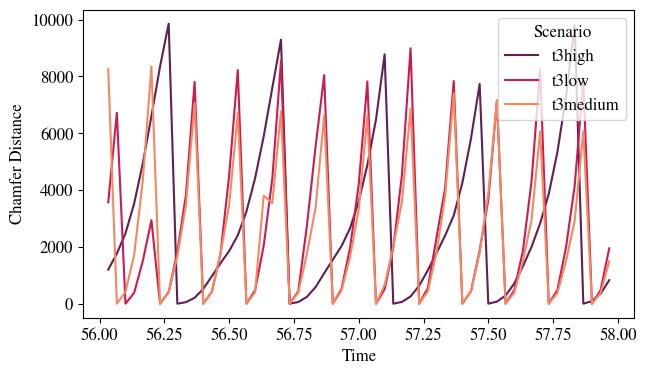

In [190]:
df_cd_retr = [cd_penta,
              np.concatenate((np.arange(scenario_cd_penta.count("t3low"))/30,
                              np.arange(scenario_cd_penta.count("t3medium"))/30, 
                              np.arange(scenario_cd_penta.count("t3high"))/30))] 
df_cd_retr = np.array(df_cd_retr)
df_cd_retr = df_cd_retr.T
df_cd_retr = pd.DataFrame(df_cd_retr, columns=["Chamfer Distance", "Time"])
# df_cd_retr["Mode"] = pd.Categorical((["Ground Truth",] * time_delay + ["ICP allignement",]* time_delay) * n_magic_rep) 
df_cd_retr["Scenario"] = pd.Categorical(scenario_cd_penta)
fig = plt.figure()
ax = fig.add_subplot(111)
time_of_interest = 56
df_cd_retr_zoom = df_cd_retr[df_cd_retr["Time"] < time_of_interest+2]
df_cd_retr_zoom = df_cd_retr_zoom[df_cd_retr_zoom["Time"] > time_of_interest]
sns.lineplot(data=df_cd_retr_zoom, x="Time", y="Chamfer Distance", dashes=True, hue="Scenario", palette="rocket", errorbar=None, ax=ax)

plt.savefig("output/latexplot/cd_retr_zoom.png")
tikzplotlib.save("output/latexplot/cd_retr_zoom.tex")
plt.show()

# The Simulation Class

In [2]:
%load_ext autoreload
%autoreload 2

from corr_study.simulation import *
from corr_study.datasetApi import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
sim = Simulation("t3high", Weather.Clear, Time.Sunset, [Sensor.LT, Sensor.LFL, Sensor.LFR], verbose=True)


Ego vehicle found as <HDF5 group "/BBOX/0109" (6 members)> 

Initialized simulation t3high
Weather = Weather.Clear
Time = Time.Sunset
Sensors = [<Sensor.LT: 'LIDAR_TOP'>, <Sensor.LFL: 'LIDAR_FRONT_LEFT'>, <Sensor.LFR: 'LIDAR_FRONT_RIGHT'>]


{'loc': array([[ 2.2179384e+02,  1.7881439e+02,  1.9676304e+00],
        [ 2.2179384e+02,  1.7881439e+02,  1.9676291e+00],
        [ 2.2179384e+02,  1.7881439e+02,  1.9676321e+00],
        ...,
        [ 1.8916640e+02,  5.8840755e+01, -5.1496122e-03],
        [ 1.8916640e+02,  5.8840755e+01, -5.2611921e-03],
        [ 1.8916640e+02,  5.8840755e+01, -5.3131483e-03]], dtype=float32),
 'rot': array([[-1.1418983e+00, -4.5215778e+01,  2.0675298e-03],
        [-1.1418983e+00, -4.5215778e+01,  2.0675298e-03],
        [-1.1417549e+00, -4.5215778e+01,  2.0694777e-03],
        ...,
        [-4.2347171e-04,  1.7987444e+02, -3.0517573e-05],
        [-4.2347171e-04,  1.7987444e+02, -3.0517573e-05],
        [-4.2347171e-04,  1.7987444e+02, -3.0517573e-05]], dtype=float32)}

In [9]:
{"sensor_name": "LIDAR_FRONT_LEFT", "translation": [1.8, 0.85, 0.75], "rotation": {"yaw": -90.0}}
{"sensor_name": "LIDAR_FRONT_RIGHT", "translation": [1.8, -0.85, 0.75], "rotation": {"yaw": -90.0}}
{"sensor_name": "LIDAR_TOP", "translation": [-0.65, 0, 1.7], "rotation": {"yaw": -90.0}}

{'sensor_name': 'LIDAR_TOP',
 'translation': [-0.65, 0, 1.7],
 'rotation': {'yaw': -90.0}}

In [3]:
from corr_study.truthsetter import *

In [40]:
tfl = [1.8, 0.85, 0.75]
tfr = [1.8, -0.85, 0.75]
tt = [-0.65, 0, 1.7]

hmfl = create_homogeneous_matrix(tfl[1],tfl[0],tfl[2],0,-90,0)
hmfr = create_homogeneous_matrix(tfr[1],tfr[0],tfr[2],0,-90,0)
hmt = create_homogeneous_matrix(tt[1],tt[0],tt[2],0,-90,0)
hmt = [[1, 0, 0, 0], [0, 1, 0, 0.65], [0, 0, 1, 1.7], [0, 0, 0, 1]]
hmfl = [[-1, 0, 0, -0.85], [0, -1, 0, -1.8], [0, 0, 1, 0.75], [0, 0, 0, 1]]
hmfr = [[1, 0, 0, 0.85], [0, 1, 0, -1.8], [0, 0, 1, 0.75], [0, 0, 0, 1]]

street_height = 0.3
lfl = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LFL, 1500)
pcfl = o3d.geometry.PointCloud()
pcfl.points = o3d.utility.Vector3dVector(lfl.data)
pcfl.transform(Sensor.LFL.get_homogeneous_matrix())
arrfl = np.asarray(pcfl.points)
pcfl.points = o3d.utility.Vector3dVector(arrfl[arrfl[:,2] > street_height])
pcfl.paint_uniform_color([1,0,0])

lfr = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LFR, 1500)
pcfr = o3d.geometry.PointCloud()
pcfr.points = o3d.utility.Vector3dVector(lfr.data)
pcfr.transform(Sensor.LFR.get_homogeneous_matrix())
arrfr = np.asarray(pcfr.points)
pcfr.points = o3d.utility.Vector3dVector(arrfr[arrfr[:,2] > street_height])
pcfr.paint_uniform_color([0,0,1])

lt = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1500)
pct = o3d.geometry.PointCloud()
pct.points = o3d.utility.Vector3dVector(lt.data)
pct.transform(Sensor.LT.get_homogeneous_matrix())
arrt = np.asarray(pct.points)
pct.points = o3d.utility.Vector3dVector(arrt[arrt[:,2] > street_height])
pct.paint_uniform_color([0,1,0])


o3d.visualization.draw_geometries([pcfl, pct, pcfr])


In [32]:
from corr_study.simulation import *

In [ ]:
sim = Simulation("t3low", Weather.Clear, Time.Sunset, [Sensor.LT], verbose=True, visualize=True)
sim.simulate()

In [ ]:
print(sim.transmissions)

<HDF5 group "/BBOX/0109" (6 members)>
vehicle.seat.leon
<KeysViewHDF5 ['acceleration', 'angular_velocity', 'bounding_box', 'location', 'rotation', 'velocity']>


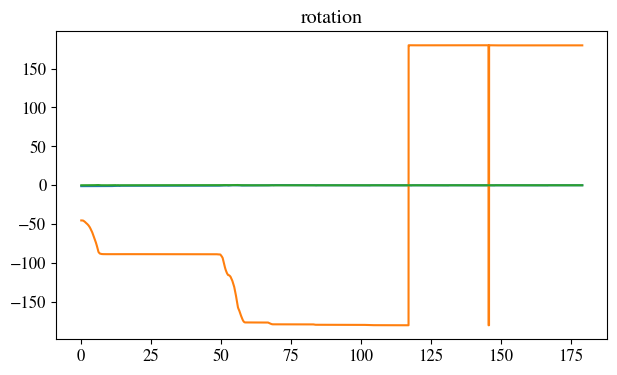

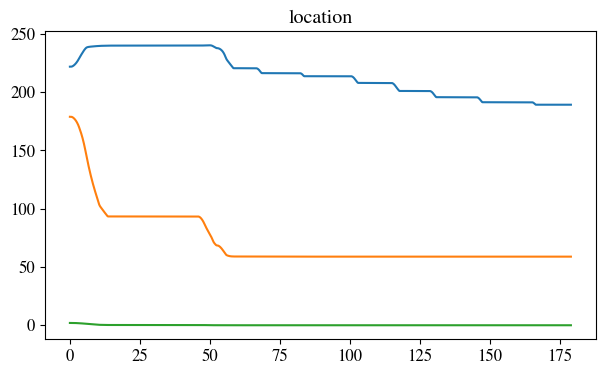

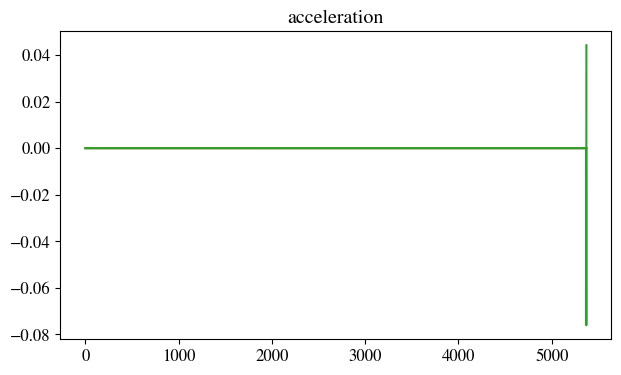

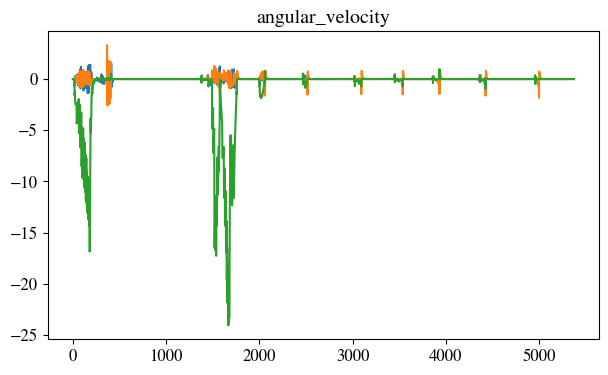

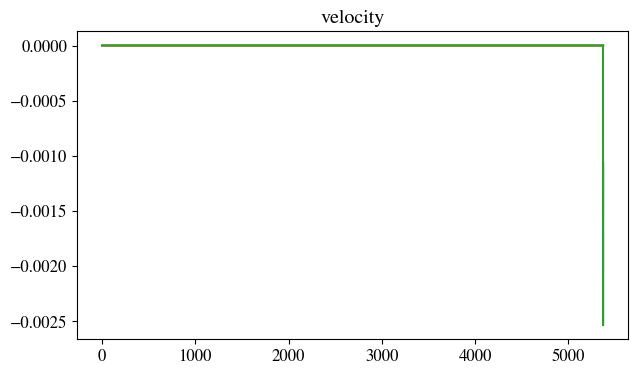

In [59]:
with h5py.File("/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5",'r') as f:
        root_grp = f.get("BBOX")
        ids = list(root_grp.keys())
        ids.sort()
        for id_actor in ids:
            agent = root_grp.get(id_actor)
            if "vehicle" in agent.attrs['type']:
                ego = root_grp.get(id_actor)
                break
        print(ego)
        print(ego.attrs["type"])
        print(ego.keys())
        loc = np.array(ego.get('location'))
        rot = np.array(ego.get('rotation'))
        acc = np.array(ego.get('acceleration'))
        avc = np.array(ego.get('angular_velocity'))
        bb = np.array(ego.get('bounding_box'))
        vel = np.array(ego.get('velocity'))
plt.plot(np.arange(rot.shape[0])/30,rot)
plt.title("rotation")
plt.show()
plt.plot(np.arange(rot.shape[0])/30,loc)
plt.title("location")
plt.show()
plt.plot(acc)
plt.title("acceleration")
plt.show()
plt.title("angular_velocity")
plt.plot(avc)
plt.show()
plt.title("velocity")
plt.plot(vel)
plt.show()

In [34]:
plot_all_toghether(
                   dataset,
                   100,
                   0,
                   "t3low",
                   Weather.Clear,
                   Time.Sunset,
                   [Sensor.LT, Sensor.LFL, Sensor.LFR])

100%|██████████| 33/33 [00:06<00:00,  5.03it/s]


In [6]:
%load_ext autoreload
%autoreload 2
import cProfile
from corr_study.simulation import *
from corr_study.datasetApi import *
simlow = Simulation("t3low", Weather.Clear, Time.Sunset, [Sensor.LT, Sensor.LFL, Sensor.LFR], verbose=False, visualize=True)
simlow.simulate()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 999/999 [04:45<00:00,  3.49it/s]


In [ ]:
print(np.count_nonzero(sim.transmissions))

302


In [7]:
simhigh = Simulation("t3high", Weather.Clear, Time.Sunset, [Sensor.LT, Sensor.LFL, Sensor.LFR], verbose=False, visualize=True)
simhigh.simulate()

100%|██████████| 999/999 [05:12<00:00,  3.20it/s]


In [ ]:
print(np.count_nonzero(simhigh.transmissions))

457


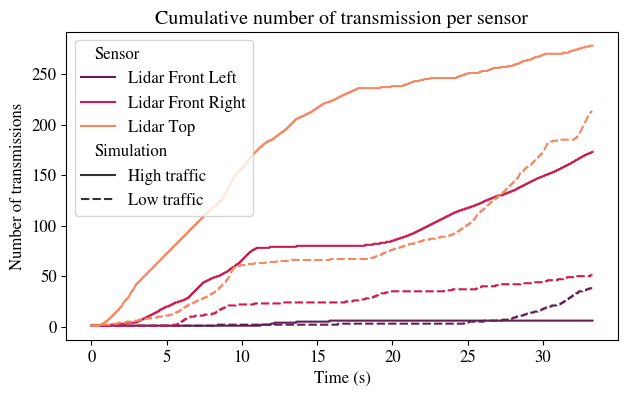

In [35]:
n_trans_low = np.cumsum(simlow.transmissions, axis=0)
n_trans_high = np.cumsum(simhigh.transmissions, axis=0)

n_frames_low = n_trans_low.shape[0] 
n_frames_high = n_trans_high.shape[0] 

n_trans_low = n_trans_low.flatten("F")
n_trans_high = n_trans_high.flatten("F")
n_trans = np.concatenate((n_trans_low, n_trans_high))

time_istants_low = np.tile(np.arange(n_frames_low)/30, 3)
time_istants_high = np.tile(np.arange(n_frames_high)/30, 3)
time_istants = np.concatenate((time_istants_low, time_istants_high))

data = np.array([n_trans, time_istants])
data = data.T

sensor = ["Lidar Top",] * n_frames_low + ["Lidar Front Left",] * n_frames_low + ["Lidar Front Right",] * n_frames_low + ["Lidar Top",] * n_frames_high + ["Lidar Front Left",] * n_frames_high + ["Lidar Front Right",] * n_frames_high
sim_name = ["Low traffic",] * 3 * n_frames_low + ["High traffic",] * 3 * n_frames_high
df = pd.DataFrame(data, columns=["Number of transmissions", "Time (s)"])

df["Sensor"] = pd.Categorical(sensor)
df["Simulation"] = pd.Categorical(sim_name)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(df, x = "Time (s)", y ="Number of transmissions", dashes=True, hue="Sensor", palette="rocket", style="Simulation", errorbar=None, ax=ax)

plt.title("Cumulative number of transmission per sensor")
plt.savefig("output/latexplot/cumulative_trans_sensor.png")
tikzplotlib.save("output/latexplot/cumulative_trans_sensor.tex")
plt.show()


In [16]:
with h5py.File("/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3medium/ClearSunset/BBOX.hdf5",'r') as f:
    root_grp = f.get("BBOX")
    ids = list(root_grp.keys())
    ids.sort()
    for id_actor in ids:
        agent = root_grp.get(id_actor)
        if "vehicle" in agent.attrs['type']:
            ego = root_grp.get(id_actor)
            break
    print(ego)
    print(ego.attrs["type"])
    print(ego.keys())
    loc = np.array(ego.get('location'))
    rot = np.array(ego.get('rotation'))
    acc = np.array(ego.get('acceleration'))
    avc = np.array(ego.get('angular_velocity'))
    bb = np.array(ego.get('bounding_box'))
    vel = np.array(ego.get('velocity'))
np.savetxt("locmedium.csv", loc, delimiter=",", fmt="%f")

<HDF5 group "/BBOX/0171" (6 members)>
vehicle.seat.leon
<KeysViewHDF5 ['acceleration', 'angular_velocity', 'bounding_box', 'location', 'rotation', 'velocity']>


In [54]:
with h5py.File("/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5",'r') as f:
        root_grp = f.get("BBOX")
        ids = list(root_grp.keys())
        ids.sort()
        for id_actor in ids:
            agent = root_grp.get(id_actor)
            if "vehicle" in agent.attrs['type']:
                ego = root_grp.get(id_actor)
                break
        print(ego)
        print(ego.attrs["type"])
        print(ego.keys())
        loc = np.array(ego.get('location'))
        rot = np.array(ego.get('rotation'))
        acc = np.array(ego.get('acceleration'))
        avc = np.array(ego.get('angular_velocity'))
        bb = np.array(ego.get('bounding_box'))
        vel = np.array(ego.get('velocity'))
print(bb.shape)
p = bb[0].T

<HDF5 group "/BBOX/0109" (6 members)>
vehicle.seat.leon
<KeysViewHDF5 ['acceleration', 'angular_velocity', 'bounding_box', 'location', 'rotation', 'velocity']>
(5373, 3, 8)


In [1]:
vis = o3d.visualization.Visualizer()
vis.create_window()
bb0 = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(p))
bb0.color = [0,0,0]
vis.add_geometry(bb0)
for i in trange(0, bb.shape[0]):
    bbi = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bb[i].T))
    bb0.R = bbi.R
    bb0.center = bbi.center
    bb0.extent = bbi.extent
    vis.update_geometry(bb0)
    vis.poll_events()
    vis.update_renderer()

NameError: name 'o3d' is not defined